In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import re
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

#### **LOAD DATASET**

In [3]:
data = pd.read_csv('uber.csv')

#### **EDA (EXPLORATORY DATA ANALYSIS)**

In [4]:
print(data.head())

        Date      Time Booking ID         Booking Status Customer ID Vehicle Type Pickup Location  Drop Location  Cancelled Rides by Customer Reason for cancelling by Customer  Cancelled Rides by Driver Driver Cancellation Reason  Incomplete Rides Incomplete Rides Reason  Booking Value  Ride Distance  Driver Ratings  Customer Rating Payment Method
0  22-Sep-25   6:39:39   T1984811  Cancelled by Customer    C6701334         Auto  Dilshad Garden    Qutub Minar                          1.0                   Change of plans                        NaN                        NaN               NaN                     NaN            NaN            NaN             NaN              NaN            NaN
1  14-Jun-25  11:41:45   T2969701  Cancelled by Customer    C1401223         Auto      Delhi Gate  Chandni Chowk                          1.0                   Change of plans                        NaN                        NaN               NaN                     NaN            NaN            Na

In [5]:
print(f"Total Records: {len(data):,}")
print(f"Total Columns: {len(data.columns)}")

Total Records: 150,000
Total Columns: 19


In [6]:
print(data.dtypes)

Date                                  object
Time                                  object
Booking ID                            object
Booking Status                        object
Customer ID                           object
Vehicle Type                          object
Pickup Location                       object
Drop Location                         object
Cancelled Rides by Customer          float64
Reason for cancelling by Customer     object
Cancelled Rides by Driver            float64
Driver Cancellation Reason            object
Incomplete Rides                     float64
Incomplete Rides Reason               object
Booking Value                        float64
Ride Distance                        float64
Driver Ratings                       float64
Customer Rating                      float64
Payment Method                        object
dtype: object


#### **CLEAN DATA**

In [7]:
# Convert numeric columns
num_cols = ['Booking Value', 'Ride Distance', 'Driver Ratings', 'Customer Rating']
data[num_cols] = data[num_cols].apply(pd.to_numeric, errors='coerce')

In [8]:
# Fill missing values - Numeric with median
data[num_cols] = data[num_cols].fillna(data[num_cols].median())

In [9]:
# Fill missing values - Categorical with "Unknown"
cat_cols = data.select_dtypes(include='object').columns
data[cat_cols] = data[cat_cols].fillna('Unknown')

#### **CREATE NEW FEATURES**

In [10]:
# Create datetime column
data['Booking_DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], errors='coerce')
data['Booking_Hour'] = data['Booking_DateTime'].dt.hour
data['Booking_Weekday'] = data['Booking_DateTime'].dt.dayofweek
data['Booking_WeekdayName'] = data['Booking_DateTime'].dt.day_name()

In [11]:
# Create cancellation flag
data['Is_Cancelled'] = data['Booking Status'].str.lower().str.contains('cancel', na=False).astype(int)

In [12]:
# Create price per km
data['Ride Distance'] = data['Ride Distance'].replace(0, np.nan)
data['Price_Per_KM'] = data['Booking Value'] / data['Ride Distance']

#### **PLOTTING ANALYZE DATA**

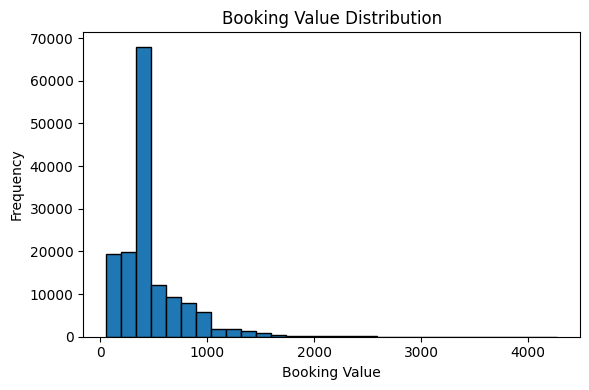

In [13]:
plt.figure(figsize=(6, 4))
plt.hist(data['Booking Value'].dropna(), edgecolor='black', bins=30)
plt.title('Booking Value Distribution')
plt.xlabel('Booking Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


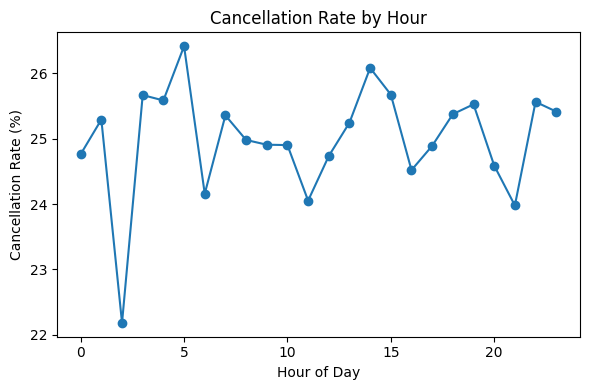

In [14]:
hourly_cancel = data.groupby('Booking_Hour')['Is_Cancelled'].mean() * 100

plt.figure(figsize=(6, 4))
plt.plot(hourly_cancel.index, hourly_cancel.values, marker='o')
plt.title('Cancellation Rate by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Cancellation Rate (%)')
plt.tight_layout()
plt.show()


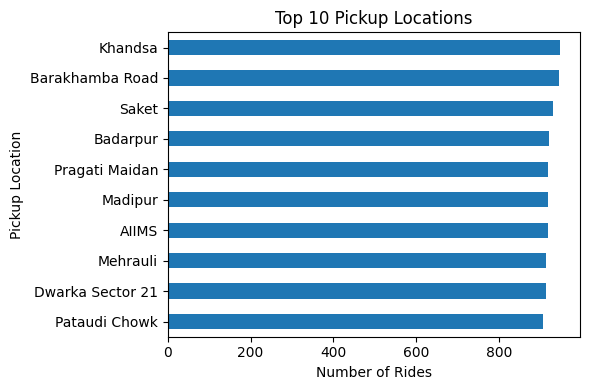

In [15]:
top_locations = data['Pickup Location'].value_counts().head(10)

plt.figure(figsize=(6, 4))
top_locations.plot(kind='barh')
plt.title('Top 10 Pickup Locations')
plt.xlabel('Number of Rides')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


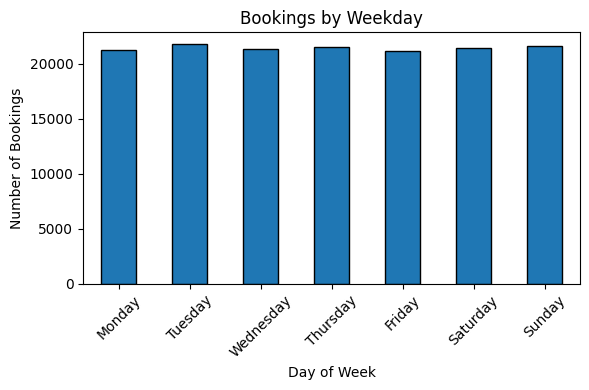

In [16]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts = data['Booking_WeekdayName'].value_counts().reindex(weekday_order)

plt.figure(figsize=(6, 4))
weekday_counts.plot(kind='bar', edgecolor='black')
plt.title('Bookings by Weekday')
plt.xlabel('Day of Week')
plt.ylabel('Number of Bookings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [17]:
data.to_csv('uber_cleaned_data.csv', index=False)

In [18]:
print(f"\nTotal Records: {len(data):,}")
print(f"Total Columns: {len(data.columns)}")
print(f"Total Booking Value: {data['Booking Value'].sum():,.2f}")
print(f"Average Booking Value: {data['Booking Value'].mean():,.2f}")
print(f"Total Cancelled: {data['Is_Cancelled'].sum():,}")
print(f"Cancellation Rate: {(data['Is_Cancelled'].mean() * 100):.2f}%")


Total Records: 150,000
Total Columns: 25
Total Booking Value: 71,718,183.00
Average Booking Value: 478.12
Total Cancelled: 37,500
Cancellation Rate: 25.00%


In [29]:
# Convert to lowercase
data.columns = data.columns.str.lower()

# Replace spaces with underscores
data.columns = data.columns.str.replace(' ', '_', regex=False)

# Replace hyphens with underscores (optional but recommended)
data.columns = data.columns.str.replace('-', '_', regex=False)


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   date                               150000 non-null  object        
 1   time                               150000 non-null  object        
 2   booking_id                         150000 non-null  object        
 3   booking_status                     150000 non-null  object        
 4   customer_id                        150000 non-null  object        
 5   vehicle_type                       150000 non-null  object        
 6   pickup_location                    150000 non-null  object        
 7   drop_location                      150000 non-null  object        
 8   cancelled_rides_by_customer        10500 non-null   float64       
 9   reason_for_cancelling_by_customer  150000 non-null  object        
 10  cancelled_rides_by_d

In [32]:
from sqlalchemy import create_engine

# Connecting to MySQL Server
username = "root"
password = "Root"
host = "localhost"
port = "3306"
database = "uber_database"

# SQLAlchemy connection string
engine = create_engine(f"mysql+pymysql://{username}:{password}@{host}:{port}/{database}")

# Loading DataFrame into MySQL
table_name = "bookings"
data.to_sql(table_name, engine, if_exists="replace", index=False)

print(f"Data Successfully Loaded into table '{table_name}' in database '{database}'.")

Data Successfully Loaded into table 'bookings' in database 'uber_database'.
